In [262]:
from sklearn import datasets
from sklearn.utils.extmath import softmax
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np
from mlxtend.plotting import plot_decision_regions

In [213]:
np.array([[3, 3], [0, 0.5]]).T

array([[3. , 0. ],
       [3. , 0.5]])

In [257]:
dist_pos = multivariate_normal([4, 6], [[2, -4], [0, 4]])

dist_neg_1 = multivariate_normal([0, 0], [[2, 0], [0, 1]])
dist_neg_2 = multivariate_normal([10, 6], [[1, 0], [0, 2]])

In [303]:
class DistWithPrior:
    
    def __init__(self, dist, prior):
        self.dist = dist
        self.prior = prior
        
class MockSklearn:
    
    def __init__(self, pos_dists, neg_dists):
        self.pos_dists = pos_dists
        self.neg_dists = neg_dists
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
        
    def predict_proba(self, X):
        pos_norm = np.column_stack([dist_prior.dist.pdf(X) * dist_prior.prior for dist_prior in self.pos_dists])
        neg_norm = np.column_stack([dist_prior.dist.pdf(X) * dist_prior.prior for dist_prior in self.neg_dists])
        
        pos_prob = np.sum(pos_norm, axis=1) / (np.sum(pos_norm, axis=1) + np.sum(neg_norm, axis=1))
        return softmax(np.column_stack((1 - pos_prob, pos_prob)))

In [322]:
n_points_dist = 400
SEED = 1234

X = np.row_stack((    
    dist_pos.rvs(size=n_points_dist, random_state=SEED),
    dist_neg_1.rvs(size=n_points_dist, random_state=SEED),
    dist_neg_2.rvs(size=n_points_dist, random_state=SEED)
))

y = np.array([0] * n_points_dist + [1] * 2 * n_points_dist)


clf = MockSklearn([DistWithPrior(dist_pos, n_points_dist / 2)], [DistWithPrior(dist_neg_1, n_points_dist / 4), DistWithPrior(dist_neg_2, n_points_dist / 4)])

/home/rrunix/anaconda3/envs/thesis/lib/python3.9/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [384]:
point = np.array([[2.3, 2.1], [10, 6], [5, 5]])

<AxesSubplot:>

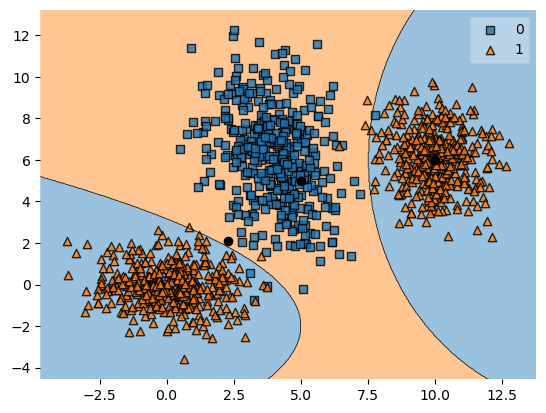

In [348]:
plot = plot_decision_regions(X, y, clf)
plt.savefig("imgs/decision_regions.png", dpi=600)
plot.scatter(point[:, 0], point[:, 1], c='black')
plot

In [537]:
def plot_decision_boundary(bounds, f, points, ax, fig=None, max_radius=None):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, points),
                         np.linspace(y_min, y_max, points))

    # Use the model to predict the outcomes on the grid
    Z = f(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if max_radius is not None:
        Z[Z >= max_radius] = np.nan
    
    # Plot the decision boundary
    cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True)
    
    if max_radius is not None:
        z_in = np.zeros_like(Z)
        z_in[np.isnan(Z)] = 1
        ax.contourf(xx, yy, z_in, 3, hatches=['', '/'],  alpha=0.1, colors='none')
        
        
    return ax

/tmp/ipykernel_9139/3668582159.py:12: UserWarning: linewidths is ignored by contourf
  ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True)
/tmp/ipykernel_9139/4030649799.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


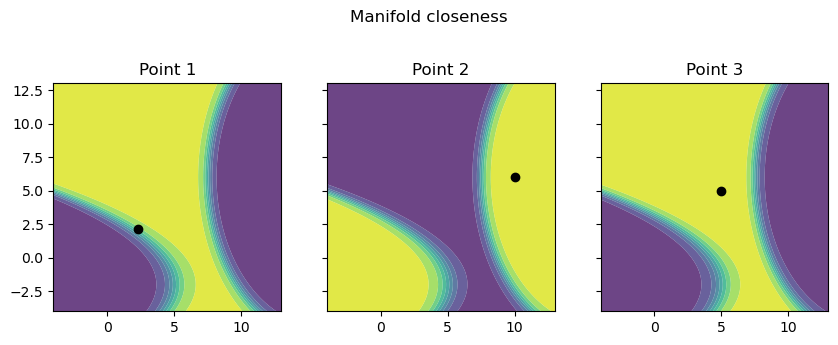

In [453]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)


def manifold_closeness(clf, factual):
    factual_prob = clf.predict_proba(factual.reshape(1, -1))
    idx = np.argmax(factual_prob.ravel())
    
    def impl(X):
        return (factual_prob + clf.predict_proba(X))[:, idx]
    return impl

manifold_plot_1_distance = manifold_closeness(clf, point[0, :])
manifold_plot_2_distance = manifold_closeness(clf, point[1, :])
manifold_plot_3_distance = manifold_closeness(clf, point[2, :])

plot_decision_boundary([[-4, 13], [-4, 13]], manifold_plot_1_distance, 1000, ax=ax1)
plot_decision_boundary([[-4, 13], [-4, 13]], manifold_plot_2_distance, 1000, ax=ax2)
plot_decision_boundary([[-4, 13], [-4, 13]], manifold_plot_3_distance, 1000, ax=ax3)


ax1.set_title("Point 1")
ax1.scatter(point[0, 0], point[0, 1], c='black')

ax2.set_title("Point 2")
ax2.scatter(point[1, 0], point[1, 1], c='black')

ax3.set_title("Point 3")
ax3.scatter(point[2, 0], point[2, 1], c='black')

fig.suptitle("Manifold closeness", y=1.1)

fig.savefig("imgs/manifold_closeness.png", dpi=600)

fig.tight_layout()

/tmp/ipykernel_9139/3668582159.py:12: UserWarning: linewidths is ignored by contourf
  ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True)
/tmp/ipykernel_9139/274309707.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


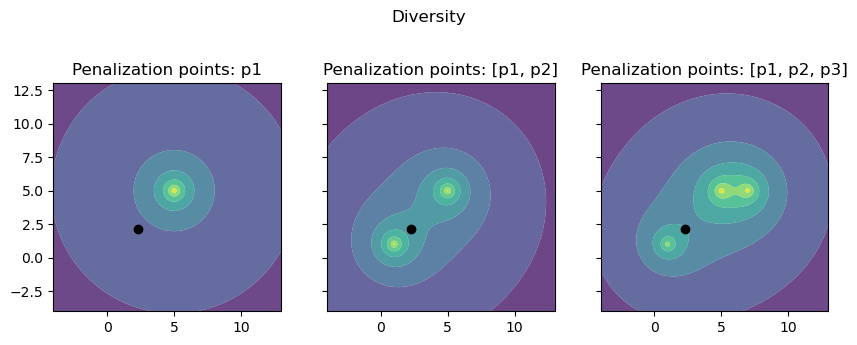

In [452]:
def penalization(p1, p2):
    return 1 / (1 + np.linalg.norm(p1 - p2, axis=1))

def penalization_function(base, points, penalization_f=penalization):
    
    def impl(X):
        acc = 0
        for point in points:
            acc += penalization_f(base, point.reshape(1, -1)).ravel() + penalization(X, point)
            
        return acc
    
    return impl


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)


penalization_points = np.array([[5, 5], [1, 1], [7, 5]])

diversity_plot_1_function = penalization_function(point[0, :], penalization_points[[0], :])
diversity_plot_2_function = penalization_function(point[1, :], penalization_points[[0, 1], :])
diversity_plot_3_function = penalization_function(point[2, :], penalization_points[[0, 1, 2], :])

plot_decision_boundary([[-4, 13], [-4, 13]], diversity_plot_1_function, 1000, ax=ax1)
plot_decision_boundary([[-4, 13], [-4, 13]], diversity_plot_2_function, 1000, ax=ax2)
plot_decision_boundary([[-4, 13], [-4, 13]], diversity_plot_3_function, 1000, ax=ax3)


ax1.set_title("Penalization points: p1")
ax1.scatter(point[0, 0], point[0, 1], c='black')

ax2.set_title("Penalization points: [p1, p2]")
ax2.scatter(point[0, 0], point[0, 1], c='black')

ax3.set_title("Penalization points: [p1, p2, p3]")
ax3.scatter(point[0, 0], point[0, 1], c='black')

fig.suptitle("Diversity", y=1.1)

fig.savefig("imgs/diversity_function.png", dpi=600)

fig.tight_layout()

/tmp/ipykernel_9139/3668582159.py:12: UserWarning: linewidths is ignored by contourf
  ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True)
/tmp/ipykernel_9139/615875263.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


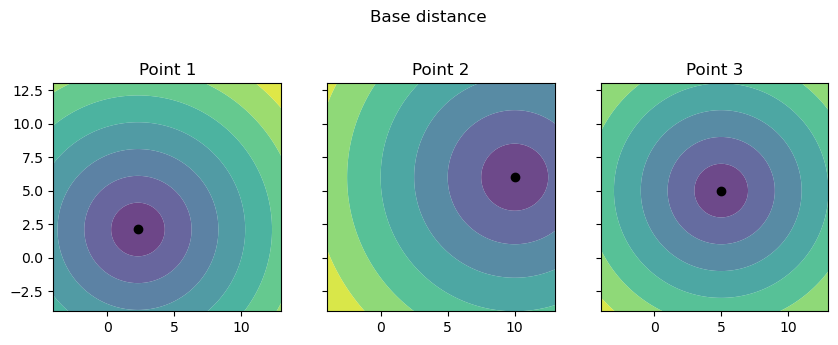

In [451]:
distance_function = lambda x, y: np.linalg.norm(x - y, axis=1)


def distance_function_wrapper(base_point, distance=distance_function):
    
    def impl(X):
        return distance(base_point, X)
    
    return impl


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)

base_plot_1_distance = distance_function_wrapper(point[0, :])
base_plot_2_distance = distance_function_wrapper(point[1, :])
base_plot_3_distance = distance_function_wrapper(point[2, :])

plot_decision_boundary([[-4, 13], [-4, 13]], base_plot_1_distance, 1000, ax=ax1)
plot_decision_boundary([[-4, 13], [-4, 13]], base_plot_2_distance, 1000, ax=ax2)
plot_decision_boundary([[-4, 13], [-4, 13]], base_plot_3_distance, 1000, ax=ax3)


ax1.set_title("Point 1")
ax1.scatter(point[0, 0], point[0, 1], c='black')

ax2.set_title("Point 2")
ax2.scatter(point[1, 0], point[1, 1], c='black')

ax3.set_title("Point 3")
ax3.scatter(point[2, 0], point[2, 1], c='black')

fig.suptitle("Base distance", y=1.1)

fig.savefig("imgs/base_distance.png", dpi=600)

fig.tight_layout()

/tmp/ipykernel_9139/4057905690.py:15: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True)
/tmp/ipykernel_9139/4019308923.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


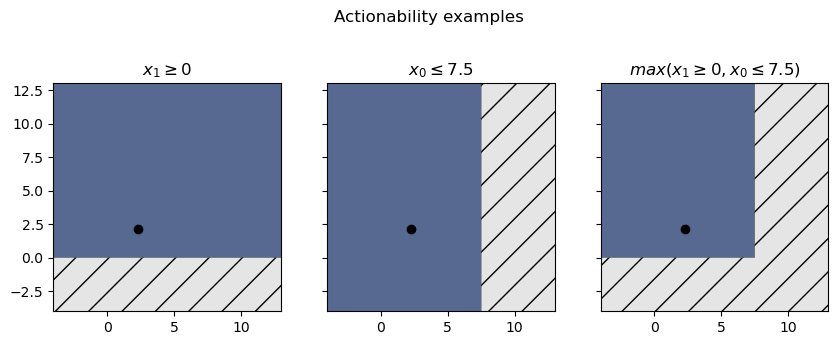

In [538]:
def actionability_wrapper(bounds, feature, penalization):
    
    def impl(X):
        distance = np.zeros(shape=X.shape[0])
        
        if bounds[0] is not None:
            distance[X[:, feature] <= bounds[0]] = penalization
            
        if bounds[1] is not None:
            distance[X[:, feature] >= bounds[1]] = penalization
            
        return distance
    
    return impl



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True, sharex=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)

penalization_value = 10

actionability_plot_1_distance = actionability_wrapper([0, None], 1, penalization_value)
actionability_plot_2_distance = actionability_wrapper([None, 7.5], 0, penalization_value)
actionability_plot_3_distance =  lambda X: np.maximum(actionability_plot_1_distance(X), actionability_plot_2_distance(X))

plot_decision_boundary([[-4, 13], [-4, 13]], actionability_plot_1_distance, 1000, ax=ax1, max_radius=penalization_value)
plot_decision_boundary([[-4, 13], [-4, 13]], actionability_plot_2_distance, 1000, ax=ax2, max_radius=penalization_value)
plot_decision_boundary([[-4, 13], [-4, 13]], actionability_plot_3_distance, 1000, ax=ax3, max_radius=penalization_value)


ax1.set_title("$x_1 \geq 0$")
ax1.scatter(point[0, 0], point[0, 1], c='black')

ax2.set_title("$x_0 \leq 7.5$")
ax2.scatter(point[0, 0], point[0, 1], c='black')

ax3.set_title("$max (x_1 \geq 0, x_0 \leq 7.5)$")
ax3.scatter(point[0, 0], point[0, 1], c='black')

fig.suptitle("Actionability examples", y=1.1)

fig.savefig("imgs/actionability_example.png", dpi=600)

fig.tight_layout()

In [500]:
def sum_combination(distances):
    
    def impl(X):
        res = 0
        
        for distance in distances:
            res += distance(X)
            
        return res
    
    return impl

/tmp/ipykernel_9139/4057905690.py:15: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True)
/tmp/ipykernel_9139/1209756146.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


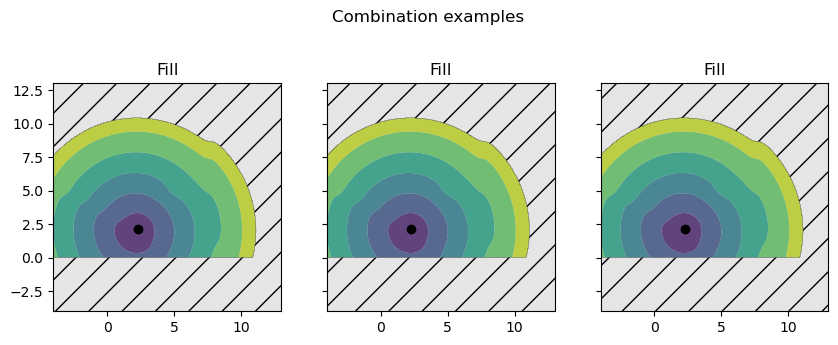

In [540]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True, sharex=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)

#fig = plt.figure()
#ax = fig.axes[0]
#ax.scatter(point[0, 0], point[0, 1], c='black')



plot_1_combination = sum_combination([actionability_plot_1_distance, base_plot_1_distance, diversity_plot_1_function, manifold_plot_1_distance])
plot_decision_boundary([[-4, 13], [-4, 13]], plot_1_combination, 1000, ax=ax1, max_radius=penalization_value)

plot_decision_boundary([[-4, 13], [-4, 13]], plot_1_combination, 1000, ax=ax2, max_radius=penalization_value)
plot_decision_boundary([[-4, 13], [-4, 13]], plot_1_combination, 1000, ax=ax3, max_radius=penalization_value)

ax1.set_title("Fill")
ax1.scatter(point[0, 0], point[0, 1], c='black')

ax2.set_title("Fill")
ax2.scatter(point[0, 0], point[0, 1], c='black')

ax3.set_title("Fill")
ax3.scatter(point[0, 0], point[0, 1], c='black')


fig.suptitle("Combination examples", y=1.1)
fig.savefig("imgs/combination_example.png", dpi=600)
fig.tight_layout()